In [31]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')

In [32]:
# Caminho do shapefile
shp_path = r"..\..\Data\Processed\PT-FireSprd_v2.1\L2_FireBehavior\PT-FireProg_v2.1_L2_model.shp"

# Carregar shapefile
gdf = gpd.read_file(shp_path)

# Inspeção inicial
print("Primeiras linhas do dataset:")
display(gdf.head())

print("\nInformações do dataset:")
print(gdf.info())

print("\nColunas disponíveis:")
print(gdf.columns.tolist())


Primeiras linhas do dataset:


,ros_p,duration_p,elev_av,aspect_sin,aspect_cos,landform,land_use,1_3y_fir_p,3_8y_fir_p,8_ny_fir_p,...,LCL_hPa_av,LFC_hPa_av,CCL_hPa_av,EL_m_av,LiftIdx_av,VentIdx_av,CMLG_av,ros_p_lg1,f_start,geometry
0,1199.641053,5.0,222.993924,-0.083639,-0.996496,21.0,4.0,0.0,0.0,97.038153,...,776.943906,NaN,603.126054,NaN,23.052628,21987.987686,1.521746,NaN,0.0,"POLYGON ((567070.391 4377440.37, 567146.283 43..."
1,397.497644,4.0,167.295794,0.259744,-0.965678,22.0,4.0,0.0,0.0,100.000000,...,799.280337,NaN,580.925947,NaN,25.889089,23552.555084,1.600810,1199.641053,300.0,"POLYGON ((568191.985 4374565.347, 568271.318 4..."
2,1092.753836,2.5,211.103842,-0.929666,-0.368404,21.0,4.0,0.0,0.0,96.002558,...,672.741767,NaN,518.699850,NaN,17.904506,7464.756538,1.769979,NaN,1080.0,"POLYGON ((563396.27 4376587.137, 563396.139 43..."
3,584.937417,7.5,184.752690,0.460585,-0.887616,21.0,4.0,0.0,0.0,98.711189,...,716.408197,NaN,531.037893,NaN,19.628183,9233.734741,1.936235,1092.753836,1230.0,"MULTIPOLYGON (((562148.15 4377681.616, 562134...."
4,708.321556,1.5,170.930441,-0.994517,0.104575,21.0,4.0,0.0,0.0,0.000000,...,826.247787,NaN,722.966350,NaN,18.231640,24199.052811,0.896715,NaN,0.0,"POLYGON ((564016.048 4350265.124, 564010.871 4..."



Informações do dataset:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 851 entries, 0 to 850
Columns: 109 entries, ros_p to geometry
dtypes: float64(108), geometry(1)
memory usage: 724.8 KB
None

Colunas disponíveis:
['ros_p', 'duration_p', 'elev_av', 'aspect_sin', 'aspect_cos', 'landform', 'land_use', '1_3y_fir_p', '3_8y_fir_p', '8_ny_fir_p', 'fuel_model', 'f_load_av', 'sW_1m_av', 'sW_3m_av', 'sW_7_av', 'sW_28_av', 'sW_100_av', 'sW_289_av', 't_2m_C_av', 'd_2m_C_av', 'rh_2m_av', 'VPD_Pa_av', 'sP_hPa_av', 'gp_m2s2_av', 'dfmc_av', 'HDW_av', 'Haines_av', 'FWI_12h_av', 'DC_12h_av', 'FFMC_12h_a', 'wv10_kh_av', 'wsin10_av', 'wcos10_av', 'wv100_k_av', 'wsin100_av', 'wcos100_av', 'Recirc', 'CircVar', 't_950_av', 't_850_av', 't_700_av', 't_500_av', 't_300_av', 'rh_950_av', 'rh_850_av', 'rh_700_av', 'rh_500_av', 'rh_300_av', 'wv_950_av', 'wv_850_av', 'wv_700_av', 'wv_500_av', 'wv_300_av', 'wsi_950_av', 'wco_950_av', 'wsi_850_av', 'wco_850_av', 'wsi_700_av', 'wco_700_av', 'wsi_500_av'

Resumo dos grupos:
 • grupo_ate_1000: 623 registros
 • grupo_1000_ate_2000: 154 registros
 • grupo_2000_ate_max: 74 registros


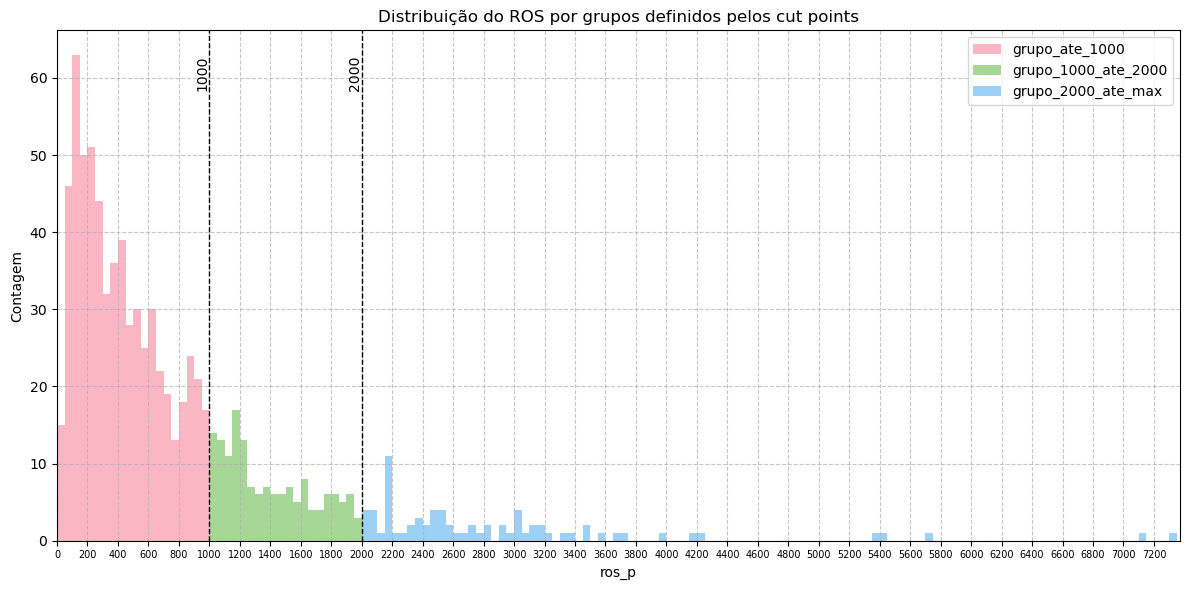

In [33]:
# Lista de limites (cut points)
cut_points = [1000, 2000]  # pode adicionar mais pontos

# Garantir ordem crescente
cut_points = sorted(cut_points)

# Criar grupos dinamicamente
grupo_dict = {}
for i, cut in enumerate(cut_points + [np.inf]):
    if i == 0:
        mask = gdf['ros_p'] <= cut
        grupo_dict[f"grupo_ate_{cut}"] = gdf[mask]
    else:
        mask = (gdf['ros_p'] > cut_points[i-1]) & (gdf['ros_p'] <= cut)
        grupo_dict[f"grupo_{cut_points[i-1]}_ate_{cut if cut != np.inf else 'max'}"] = gdf[mask]

# Resumo dos grupos
print("Resumo dos grupos:")
for name, group in grupo_dict.items():
    print(f" • {name}: {len(group)} registros")

# Definir limites do histograma
min_ros = gdf['ros_p'].min()
max_ros = gdf['ros_p'].max()
bins = np.arange(0, max_ros + 50, 50)  # bins de 50 em 50

# Plot da distribuição do ros_p com cores por grupo e cut points
plt.figure(figsize=(12,6))

# Cores para cada grupo
cores = sns.color_palette("husl", len(grupo_dict))

# Plotar histograma para cada grupo
for (name, group), cor in zip(grupo_dict.items(), cores):
    plt.hist(group['ros_p'], bins=bins, alpha=0.5, label=name, color=cor)

# Linhas verticais para cut points
for cut in cut_points:
    plt.axvline(cut, color='black', linestyle='--', linewidth=1)
    plt.text(cut, plt.ylim()[1]*0.95, f'{cut}', rotation=90,
             verticalalignment='top', horizontalalignment='right', fontsize=10)

plt.title('Distribuição do ROS por grupos definidos pelos cut points')
plt.xlabel('ros_p')
plt.ylabel('Contagem')
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Ajustar ticks do eixo x de 200 em 200
plt.xticks(np.arange(0, max_ros + 200, 200), fontsize=7)
plt.xlim(0, max_ros + 50)

plt.tight_layout()
plt.show()


In [34]:
# Identificar colunas numéricas
colunas_numericas = gdf.select_dtypes(include=[np.number]).columns.tolist()

# Remover colunas irrelevantes
colunas_nao_relevantes = ['geometry', 'FID', 'OBJECTID', 'ID', 'id']
colunas_analise = [col for col in colunas_numericas if col not in colunas_nao_relevantes and col != 'ros_p']

print(f"Colunas para análise ({len(colunas_analise)}):")
print(colunas_analise)

Colunas para análise (107):
['duration_p', 'elev_av', 'aspect_sin', 'aspect_cos', 'landform', 'land_use', '1_3y_fir_p', '3_8y_fir_p', '8_ny_fir_p', 'fuel_model', 'f_load_av', 'sW_1m_av', 'sW_3m_av', 'sW_7_av', 'sW_28_av', 'sW_100_av', 'sW_289_av', 't_2m_C_av', 'd_2m_C_av', 'rh_2m_av', 'VPD_Pa_av', 'sP_hPa_av', 'gp_m2s2_av', 'dfmc_av', 'HDW_av', 'Haines_av', 'FWI_12h_av', 'DC_12h_av', 'FFMC_12h_a', 'wv10_kh_av', 'wsin10_av', 'wcos10_av', 'wv100_k_av', 'wsin100_av', 'wcos100_av', 'Recirc', 'CircVar', 't_950_av', 't_850_av', 't_700_av', 't_500_av', 't_300_av', 'rh_950_av', 'rh_850_av', 'rh_700_av', 'rh_500_av', 'rh_300_av', 'wv_950_av', 'wv_850_av', 'wv_700_av', 'wv_500_av', 'wv_300_av', 'wsi_950_av', 'wco_950_av', 'wsi_850_av', 'wco_850_av', 'wsi_700_av', 'wco_700_av', 'wsi_500_av', 'wco_500_av', 'wsi_300_av', 'wco_300_av', 'vwv_950_av', 'vwv_850_av', 'vwv_700_av', 'vwv_500_av', 'vwv_300_av', 'gp_950_av', 'gp_850_av', 'gp_700_av', 'gp_500_av', 'gp_300_av', 'gT_s_9_av', 'gT_9_8_av', 'gT_8

In [35]:
def testar_variaveis(grupo_dict, colunas_analise):
    """
    Realiza testes estatísticos comparando o primeiro grupo com os demais.
    Retorna DataFrame com resultados.
    """
    resultados = []
    grupos = list(grupo_dict.values())
    base_grupo = grupos[0]
    outros_grupos = pd.concat(grupos[1:], axis=0)
    
    for coluna in colunas_analise:
        dados_base = base_grupo[coluna].dropna()
        dados_outros = outros_grupos[coluna].dropna()
        
        if len(dados_base) < 3 or len(dados_outros) < 3:
            resultados.append({
                'Variável': coluna,
                'Teste': 'Não aplicável',
                'Estatística': np.nan,
                'p-valor': np.nan,
                'Significativo': False
            })
            continue
        
        # Normalidade
        try:
            _, p_base = stats.shapiro(dados_base)
            _, p_outros = stats.shapiro(dados_outros)
            normal = (p_base > 0.05) and (p_outros > 0.05)
        except:
            normal = False
        
        # Teste estatístico
        try:
            if normal:
                estat, p_val = stats.ttest_ind(dados_base, dados_outros, equal_var=False)
                teste = "Teste t (Welch)"
            else:
                estat, p_val = stats.mannwhitneyu(dados_base, dados_outros)
                teste = "Mann-Whitney U"
        except:
            estat, p_val = np.nan, np.nan
            teste = "Erro"
        
        resultados.append({
            'Variável': coluna,
            'Teste': teste,
            'Estatística': estat,
            'p-valor': p_val,
            'Significativo': p_val < 0.05 if not np.isnan(p_val) else False
        })
    
    return pd.DataFrame(resultados)

# Executar testes
df_resultados = testar_variaveis(grupo_dict, colunas_analise)

In [36]:
# Comparar médias do primeiro grupo com os demais
base_grupo = list(grupo_dict.values())[0]
outros_grupos = pd.concat(list(grupo_dict.values())[1:], axis=0)

resumo = []
vars_sem_diferenca = []  # Lista para variáveis sem diferença

for coluna in colunas_analise:
    try:
        media_base = base_grupo[coluna].mean()
        media_outros = outros_grupos[coluna].mean()
        diff = media_base - media_outros
        res = df_resultados[df_resultados['Variável'] == coluna].iloc[0]
        
        resumo.append({
            'Variável': coluna,
            'Grupo Base (média)': media_base,
            'Grupo Outros (média)': media_outros,
            'Diferença': diff,
            'p-valor': res['p-valor'],
            'Significativo': res['Significativo'],
            'Teste': res['Teste']
        })
        
        # Verificar variáveis sem diferença significativa (Δ = 0)
        if np.isclose(diff, 0):
            vars_sem_diferenca.append(coluna)
            
    except:
        continue

df_resumo = pd.DataFrame(resumo)
df_resumo['abs_diferenca'] = abs(df_resumo['Diferença'])
df_resumo = df_resumo.sort_values(['Significativo', 'abs_diferenca'], ascending=[False, False])

# Print das primeiras 10 linhas do resumo
display(df_resumo.head(10))

# Print das variáveis sem diferença
if vars_sem_diferenca:
    print("\nVariáveis sem diferença entre o grupo base e os demais:")
    for var in vars_sem_diferenca:
        print(f" • {var}")
else:
    print("\nTodas as variáveis apresentam alguma diferença média.")


,Variável,Grupo Base (média),Grupo Outros (média),Diferença,p-valor,Significativo,Teste,abs_diferenca
24,HDW_av,24207.615342,38271.695425,-14064.080083,1.388592e-16,True,Mann-Whitney U,14064.080083
103,VentIdx_av,10444.565642,12130.303575,-1685.737933,9.757517e-06,True,Mann-Whitney U,1685.737933
105,ros_p_lg1,724.648954,1572.016415,-847.367461,1.747095e-20,True,Mann-Whitney U,847.367461
20,VPD_Pa_av,2151.965838,2760.245835,-608.279997,9.890034e-08,True,Mann-Whitney U,608.279997
106,f_start,1743.723917,1175.460526,568.263390,7.015329e-06,True,Mann-Whitney U,568.263390
96,BLH_m_av,777.502142,1124.574753,-347.072610,1.775107e-08,True,Mann-Whitney U,347.072610
1,elev_av,537.782363,458.447331,79.335032,6.150142e-04,True,Mann-Whitney U,79.335032
27,DC_12h_av,741.964983,787.083295,-45.118312,8.910018e-03,True,Mann-Whitney U,45.118312
98,LCL_hPa_av,771.754862,737.583870,34.170992,2.537482e-07,True,Mann-Whitney U,34.170992
86,wSv_1_av,67.330845,79.271961,-11.941115,8.899558e-06,True,Mann-Whitney U,11.941115



Todas as variáveis apresentam alguma diferença média.


In [37]:
pdf_path = f'..\..\Data\Data_Exploration\Comparacao_ROS_magnitude_{cut_points[0]}.pdf'
pdf = PdfPages(pdf_path)

df_signif = df_resumo[df_resumo['Significativo']].sort_values('abs_diferenca', ascending=False)
df_nsignif = df_resumo[~df_resumo['Significativo']].sort_values('abs_diferenca', ascending=False)
df_plot = pd.concat([df_signif, df_nsignif], axis=0)

n = len(df_plot)
cols = 4
rows = (n // cols) + (1 if n % cols != 0 else 0)
fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
axes = axes.ravel()

for i, (idx, row) in enumerate(df_plot.iterrows()):
    var = row['Variável']
    try:
        dados = pd.DataFrame({
            'Valor': pd.concat([base_grupo[var].dropna(), outros_grupos[var].dropna()]),
            'Grupo': [f'ROS ≤ {cut_points[0]}']*len(base_grupo[var].dropna()) + \
                     [f'ROS > {cut_points[0]}']*len(outros_grupos[var].dropna())
        })
        sns.boxplot(x='Grupo', y='Valor', data=dados, ax=axes[i],
                    palette={'ROS ≤ {0}'.format(cut_points[0]): 'blue',
                             'ROS > {0}'.format(cut_points[0]): 'red'})
        titulo = f"{var}\n(p = {row['p-valor']:.4f}){' ★' if row['Significativo'] else ''}"
        axes[i].set_title(titulo, fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, linestyle='--', alpha=0.5)
    except Exception as e:
        axes[i].set_title(f"Erro: {var}")
        print(f"Erro no plot de {var}: {e}")

# Remover eixos vazios
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
pdf.savefig(fig)
plt.close(fig)
pdf.close()
print(f"PDF salvo em: {pdf_path}")


PDF salvo em: ..\..\Data\Data_Exploration\Comparacao_ROS_magnitude_1000.pdf


In [38]:
df_resumo = df_resumo[['Variável', 'Grupo Base (média)', 'Grupo Outros (média)',
                                     'Diferença', 'p-valor']].copy()
df_resumo['Efeito'] = df_resumo['Diferença'].apply(lambda x: '↑ MAIOR' if x > 0 else '↓ MENOR')
df_resumo['Diferença Relativa (%)'] = ((df_resumo['Grupo Base (média)'] - df_resumo['Grupo Outros (média)']) / 
                                            df_resumo['Grupo Outros (média)']) * 100

# Formatar números
for col in ['Grupo Base (média)', 'Grupo Outros (média)', 'Diferença']:
    df_resumo[col] = df_resumo[col].round(3)
df_resumo['Diferença Relativa (%)'] = df_resumo['Diferença Relativa (%)'].round(2)
df_resumo['p-valor'] = df_resumo['p-valor'].round(4)

# Reordenar colunas
df_resumo = df_resumo[['Variável', 'Grupo Base (média)', 'Grupo Outros (média)',
                                   'Diferença', 'Diferença Relativa (%)', 'Efeito', 'p-valor']]

# Mostrar tabela
display(df_resumo)

# Salvar CSV
csv_path = f'..\..\Data\Data_Exploration\Comparacao_ROS_magnitude_{cut_points[0]}.csv'
df_resumo.to_csv(csv_path, index=False, encoding='utf-8-sig')
print(f"Tabela salva em: {csv_path}")


,Variável,Grupo Base (média),Grupo Outros (média),Diferença,Diferença Relativa (%),Efeito,p-valor
24,HDW_av,24207.615,38271.695,-14064.080,-36.75,↓ MENOR,0.0000
103,VentIdx_av,10444.566,12130.304,-1685.738,-13.90,↓ MENOR,0.0000
105,ros_p_lg1,724.649,1572.016,-847.367,-53.90,↓ MENOR,0.0000
20,VPD_Pa_av,2151.966,2760.246,-608.280,-22.04,↓ MENOR,0.0000
106,f_start,1743.724,1175.461,568.263,48.34,↑ MAIOR,0.0000
...,...,...,...,...,...,...,...
87,wSsin_1_av,-0.001,0.001,-0.002,-261.09,↓ MENOR,0.2137
62,vwv_950_av,-0.043,-0.041,-0.002,4.27,↓ MENOR,0.6156
81,wSsin_7_av,-0.002,-0.004,0.002,-47.22,↑ MAIOR,0.1666
66,vwv_300_av,0.006,0.005,0.002,33.54,↑ MAIOR,0.6984


Tabela salva em: ..\..\Data\Data_Exploration\Comparacao_ROS_magnitude_1000.csv
